# Create the model

In [22]:
from torchmdnet.models.model import create_model, load_model
from torchmdnet.utils import LoadFromFile, LoadFromCheckpoint, save_argparse, number
import argparse
from torchmdnet import datasets, priors, models
from torchmdnet.data import DataModule
from torchmdnet.models import output_modules
from torchmdnet.models.utils import rbf_class_mapping, act_class_mapping

In [23]:
def get_args():
    # fmt: off
    parser = argparse.ArgumentParser(description='Training')
    parser.add_argument('--load-model', action=LoadFromCheckpoint, help='Restart training using a model checkpoint')  # keep first
    parser.add_argument('--conf', '-c', type=open, action=LoadFromFile, help='Configuration yaml file')  # keep second
    parser.add_argument('--num-epochs', default=300, type=int, help='number of epochs')
    parser.add_argument('--batch-size', default=32, type=int, help='batch size')
    parser.add_argument('--inference-batch-size', default=None, type=int, help='Batchsize for validation and tests.')
    parser.add_argument('--lr', default=1e-4, type=float, help='learning rate')
    parser.add_argument('--lr-patience', type=int, default=10, help='Patience for lr-schedule. Patience per eval-interval of validation')
    parser.add_argument('--lr-min', type=float, default=1e-6, help='Minimum learning rate before early stop')
    parser.add_argument('--lr-factor', type=float, default=0.8, help='Minimum learning rate before early stop')
    parser.add_argument('--lr-warmup-steps', type=int, default=0, help='How many steps to warm-up over. Defaults to 0 for no warm-up')
    parser.add_argument('--early-stopping-patience', type=int, default=30, help='Stop training after this many epochs without improvement')
    parser.add_argument('--weight-decay', type=float, default=0.0, help='Weight decay strength')
    parser.add_argument('--ema-alpha-y', type=float, default=1.0, help='The amount of influence of new losses on the exponential moving average of y')
    parser.add_argument('--ema-alpha-dy', type=float, default=1.0, help='The amount of influence of new losses on the exponential moving average of dy')
    parser.add_argument('--ngpus', type=int, default=-1, help='Number of GPUs, -1 use all available. Use CUDA_VISIBLE_DEVICES=1, to decide gpus')
    parser.add_argument('--num-nodes', type=int, default=1, help='Number of nodes')
    parser.add_argument('--precision', type=int, default=32, choices=[16, 32], help='Floating point precision')
    parser.add_argument('--log-dir', '-l', default='/tmp/logs', help='log file')
    parser.add_argument('--splits', default=None, help='Npz with splits idx_train, idx_val, idx_test')
    parser.add_argument('--train-size', type=number, default=None, help='Percentage/number of samples in training set (None to use all remaining samples)')
    parser.add_argument('--val-size', type=number, default=0.05, help='Percentage/number of samples in validation set (None to use all remaining samples)')
    parser.add_argument('--test-size', type=number, default=0.1, help='Percentage/number of samples in test set (None to use all remaining samples)')
    parser.add_argument('--test-interval', type=int, default=10, help='Test interval, one test per n epochs (default: 10)')
    parser.add_argument('--save-interval', type=int, default=10, help='Save interval, one save per n epochs (default: 10)')
    parser.add_argument('--seed', type=int, default=1, help='random seed (default: 1)')
    parser.add_argument('--distributed-backend', default='ddp', help='Distributed backend: dp, ddp, ddp2')
    parser.add_argument('--num-workers', type=int, default=4, help='Number of workers for data prefetch')
    parser.add_argument('--redirect', type=bool, default=False, help='Redirect stdout and stderr to log_dir/log')
    
    # model architecture
    parser.add_argument('--model', type=str, default='graph-network', choices=models.__all__, help='Which model to train')
    parser.add_argument('--output-model', type=str, default='Scalar', choices=output_modules.__all__, help='The type of output model')
    parser.add_argument('--prior-model', type=str, default=None, choices=priors.__all__, help='Which prior model to use')

    # architectural args
    parser.add_argument('--embedding-dimension', type=int, default=256, help='Embedding dimension')
    parser.add_argument('--num-layers', type=int, default=6, help='Number of interaction layers in the model')
    parser.add_argument('--num-rbf', type=int, default=64, help='Number of radial basis functions in model')
    parser.add_argument('--activation', type=str, default='silu', choices=list(act_class_mapping.keys()), help='Activation function')
    parser.add_argument('--rbf-type', type=str, default='expnorm', choices=list(rbf_class_mapping.keys()), help='Type of distance expansion')
    parser.add_argument('--trainable-rbf', type=bool, default=False, help='If distance expansion functions should be trainable')
    parser.add_argument('--neighbor-embedding', type=bool, default=False, help='If a neighbor embedding should be applied before interactions')
    
    # dataset specific
    parser.add_argument('--dataset', default=None, type=str, choices=datasets.__all__, help='Name of the torch_geometric dataset')
    parser.add_argument('--dataset-root', default='~/data', type=str, help='Data storage directory (not used if dataset is "CG")')
    parser.add_argument('--dataset-arg', default=None, type=str, help='Additional dataset argument, e.g. target property for QM9 or molecule for MD17')
    parser.add_argument('--coord-files', default=None, type=str, help='Custom coordinate files glob')
    parser.add_argument('--embed-files', default=None, type=str, help='Custom embedding files glob')
    parser.add_argument('--energy-files', default=None, type=str, help='Custom energy files glob')
    parser.add_argument('--force-files', default=None, type=str, help='Custom force files glob')
    parser.add_argument('--energy-weight', default=1.0, type=float, help='Weighting factor for energies in the loss function')
    parser.add_argument('--force-weight', default=1.0, type=float, help='Weighting factor for forces in the loss function')

    # Transformer specific
    parser.add_argument('--distance-influence', type=str, default='both', choices=['keys', 'values', 'both', 'none'], help='Where distance information is included inside the attention')
    parser.add_argument('--attn-activation', default='silu', choices=list(act_class_mapping.keys()), help='Attention activation function')
    parser.add_argument('--num-heads', type=int, default=8, help='Number of attention heads')

    # other args
    parser.add_argument('--derivative', default=True, type=bool, help='If true, take the derivative of the prediction w.r.t coordinates')
    parser.add_argument('--cutoff-lower', type=float, default=0.0, help='Lower cutoff in model')
    parser.add_argument('--cutoff-upper', type=float, default=5.0, help='Upper cutoff in model')
    parser.add_argument('--atom-filter', type=int, default=-1, help='Only sum over atoms with Z > atom_filter')
    parser.add_argument('--max-z', type=int, default=100, help='Maximum atomic number that fits in the embedding matrix')
    parser.add_argument('--max-num-neighbors', type=int, default=32, help='Maximum number of neighbors to consider in the network')
    parser.add_argument('--standardize', type=bool, default=False, help='If true, multiply prediction by dataset std and add mean')
    parser.add_argument('--reduce-op', type=str, default='add', choices=['add', 'mean'], help='Reduce operation to apply to atomic predictions')

    args = parser.parse_args("")
    all_defaults = {}
    for key in vars(args):
        all_defaults[key] = parser.get_default(key)
    
    return all_defaults

In [24]:
args = get_args()
prior_model=None
mean=None
std=None

In [25]:
gnn = create_model(args, prior_model, mean, std)

In [26]:
list(gnn.parameters())[0]

Parameter containing:
tensor([[ 0.2285,  0.1705,  1.3554,  ...,  0.1563, -1.5766, -1.1985],
        [-0.1755,  2.1589,  1.1211,  ..., -1.0757, -0.5105, -0.6262],
        [ 0.2246, -0.8468, -1.1987,  ..., -0.1815,  0.7221,  2.1515],
        ...,
        [ 1.8066, -0.3609,  1.9609,  ...,  0.0989,  0.0346, -1.1021],
        [-0.8289, -0.4497, -0.7575,  ...,  0.8243,  0.5471, -0.8125],
        [ 0.5150,  1.9791, -0.6377,  ..., -1.3767,  0.0845,  0.1043]],
       requires_grad=True)

# Prepare system

In [27]:
from moleculekit.molecule import Molecule
from torchmd.forcefields.ff_yaml import YamlForcefield
from torchmd.forcefields.forcefield import ForceField
from torchmd.forces import Forces
from torchmd.integrator import Integrator, maxwell_boltzmann
from torchmd.parameters import Parameters
from torchmd.systems import System
from torchmd.wrapper import Wrapper
from tqdm import tqdm
from utils import rmsd

In [28]:
# Molecule
mol = Molecule('data/chignolin_cln025.pdb')
mol.filter('name CA')
mol.read('data/chignolin_ca_top.psf')
mol.read('data/chignolin_ca_initial_coords.xtc')

2021-08-31 12:58:01,357 - moleculekit.molecule - INFO - Removed 83 atoms. 10 atoms remaining in the molecule.


In [29]:
mol.coords.shape[2]

10

# Train created model

In [30]:
gnn.derivative

True

In [31]:
from torchmdexp.nn.utils import get_embeddings
get_embeddings(mol)

array([ 4,  4,  5,  8,  6, 13,  2, 13,  7,  4])

In [32]:
import torch
from torchmdnet.models.model import load_model

class External:
    def __init__(self, model, embeddings, device="cpu"):
        self.model = model
        self.device = device
        self.n_atoms = embeddings.size(1)
        self.embeddings = embeddings.reshape(-1).to(device)
        self.batch = torch.arange(embeddings.size(0), device=device).repeat_interleave(
            embeddings.size(1)
        )
        #self.model.eval()

    def calculate(self, pos, box):
        pos = pos.to(self.device).type(torch.float32).reshape(-1, 3)
        energy, forces = self.model(self.embeddings, pos, self.batch)
        #print(energy, forces)
        return energy, forces.reshape(-1, self.n_atoms, 3)


In [33]:
# Loading the model as external force

embeddings = [4, 4, 5, 8, 6, 13, 2, 13, 7, 4]
#model = torch.load('data/epoch=47-val_loss=739.5398-test_loss=21.5975.ckpt')
device = 'cpu'

#externalmodule = importlib.import_module('torchmdnet.calculators')
embeddings = torch.tensor(embeddings).repeat(10, 1)
external = External(gnn, embeddings, device)

In [34]:
ff = ForceField.create(mol,'/shared/carles/torchmd-exp/torchmdexp/nn/data/ca_priors-dihedrals_general_2xweaker.yaml')
cln_parameters = Parameters(ff, mol, terms=['bonds', 'repulsionCG', 'dihedrals'], device=device)
forces = Forces(cln_parameters, terms=['bonds', 'repulsionCG', 'dihedrals'], external=external, cutoff=None, 
                rfa=False, switch_dist=None
               )

In [35]:
# System
system = System(mol.numAtoms, nreplicas=10,precision=torch.double, device=device)
system.set_positions(mol.coords)
system.set_box(mol.box)
system.set_velocities(maxwell_boltzmann(forces.par.masses, T=350, replicas=10))

In [36]:
learning_rate = 10
optim = torch.optim.Adam(gnn.parameters(), lr=learning_rate)

In [37]:
integrator = Integrator(system, forces, 1, device, gamma=0.1, T=0)

In [38]:
native_coords = system.pos.clone().detach()

In [39]:
steps = 10
output_period = 10
n_epochs = 500
iterator = tqdm(range(1,int(steps/output_period)+1))
#Epot = forces.compute(system.pos, system.box, system.forces)

  0%|                                                     | 0/1 [00:00<?, ?it/s]

In [40]:
first_start_params = list(forces.external.model.parameters())[0].data.clone()

In [41]:
end_params_forces = torch.tensor([])
end_params_gnn = torch.tensor([])

In [42]:
rmsds = []

for epoch in range(1, n_epochs + 1):
    
    external = External(gnn, embeddings, device) 
    
    # Define forces and parameters
    ff = ForceField.create(mol,'/shared/carles/torchmd-exp/torchmdexp/nn/data/ca_priors-dihedrals_general_2xweaker.yaml')
    cln_parameters = Parameters(ff, mol, terms=['bonds', 'repulsionCG', 'dihedrals'], device=device)
    forces = Forces(cln_parameters, terms=['bonds', 'repulsionCG', 'dihedrals'], external=external, cutoff=None, 
                    rfa=False, switch_dist=None
                    )
    
    #print('Check if update params: ', torch.equal(first.data, first_first.data))
    start_params_forces = list(forces.external.model.parameters())[0].data.clone()
    start_params_gnn = list(gnn.parameters())[0].data.clone()
    
    system = System(mol.numAtoms, nreplicas=10,precision=torch.double, device=device)
    system.set_positions(mol.coords)
    system.set_box(mol.box)
    system.set_velocities(maxwell_boltzmann(forces.par.masses, T=350, replicas=10))
    integrator = Integrator(system, forces, 1, device, gamma=0.1, T=0)
        
    if (epoch % 100) == 0:
        learning_rate /= 2
    
    for i in iterator:
        Ekin, Epot, T = integrator.step(niter=output_period)
        #currpos = system.pos.clone()
    
    loss_sum = 0
    rmsd_sum = 0
    for idx, rep in enumerate(system.pos):
        loss, passed = rmsd(rep, native_coords[idx])
        log_loss = loss_log = torch.log(1.0 + loss)
        loss_sum += log_loss
        rmsd_sum += loss
    loss_sum
    
    optim.zero_grad()
    loss_sum.backward()
    optim.step()
    
    end_params_forces = list(forces.external.model.parameters())[0].data.clone()
    end_params_gnn = list(gnn.parameters())[0].data.clone()
    
    print('Check if update force params: ', torch.equal(start_params_forces.data, end_params_forces.data))
    print('Check if update gnn params: ', torch.equal(start_params_gnn.data, end_params_gnn.data))
    
    print('FORCES: ')
    print(start_params_forces.data, end_params_forces.data)
    
    print('GNN: :')
    print(start_params_gnn.data, end_params_gnn.data)
          
    print(f'Epoch {epoch}, Training loss {rmsd_sum / 10}')

        #for rep, coords in enumerate(native_coords):
        #    print('RMSD GOOD: ', rmsd(native_coords[rep], currpos[rep]))
    
    rmsds.append(loss_sum.item())

100%|█████████████████████████████████████████████| 1/1 [00:31<00:00, 31.04s/it]


Check if update force params:  False
Check if update gnn params:  False
FORCES: 
tensor([[ 0.2285,  0.1705,  1.3554,  ...,  0.1563, -1.5766, -1.1985],
        [-0.1755,  2.1589,  1.1211,  ..., -1.0757, -0.5105, -0.6262],
        [ 0.2246, -0.8468, -1.1987,  ..., -0.1815,  0.7221,  2.1515],
        ...,
        [ 1.8066, -0.3609,  1.9609,  ...,  0.0989,  0.0346, -1.1021],
        [-0.8289, -0.4497, -0.7575,  ...,  0.8243,  0.5471, -0.8125],
        [ 0.5150,  1.9791, -0.6377,  ..., -1.3767,  0.0845,  0.1043]]) tensor([[  0.2285,   0.1705,   1.3554,  ...,   0.1563,  -1.5766,  -1.1985],
        [ -0.1755,   2.1589,   1.1211,  ...,  -1.0757,  -0.5105,  -0.6262],
        [ -7.9599,   8.4924, -10.8759,  ...,   8.0394,  10.3804,  -7.5548],
        ...,
        [  1.8066,  -0.3609,   1.9609,  ...,   0.0989,   0.0346,  -1.1021],
        [ -0.8289,  -0.4497,  -0.7575,  ...,   0.8243,   0.5471,  -0.8125],
        [  0.5150,   1.9791,  -0.6377,  ...,  -1.3767,   0.0845,   0.1043]])
GNN: :
tensor([

RuntimeError: Found NaN coordinates.

In [39]:
from statistics import mean
mean(rmsds)

8.30422538327631

In [40]:
epochs = list(range(1,len(rmsds) + 1))

2021-08-27 20:14:08,899 - matplotlib.legend - WARNING - No handles with labels found to put in legend.


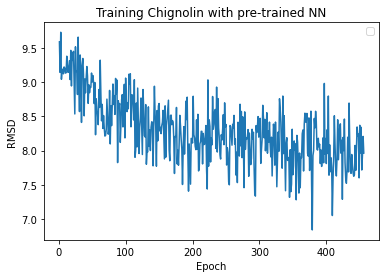

In [41]:
# Import the necessary packages and modules
import matplotlib.pyplot as plt
import numpy as np

label = ""
plt.plot(epochs, rmsds)
plt.xlabel('Epoch')
plt.ylabel('RMSD')
plt.title('Training Chignolin with pre-trained NN')
# show a legend on the plot
plt.legend()


In [99]:
loss_sum = 0
for idx, rep in enumerate(system.pos):
    loss, passed = rmsd(rep, native_coords[idx])
    log_loss = loss_log = torch.log(1.0 + loss)
    loss_sum += log_loss
loss_sum

tensor(2.1094e-14, dtype=torch.float64)

In [63]:
loss1 = torch.tensor(9)
loss2 = torch.tensor(8)
loss3 = torch.tensor(11)
loss_log = torch.log(1 + loss)

In [66]:
from math import exp
exp(loss_log)

10.000000319754372